In [4]:
## imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time
from collections import deque


In [5]:
# Load the dataset
file_path = "cs448b_ipasn.csv"
df = pd.read_csv(file_path)

# Define known compromise dates and IPs
compromise_info = {
    1: "2006-08-24",
    5: "2006-09-04",
    4: "2006-09-18",
    3: "2006-09-26",
    6: "2006-09-26"
}

# Show basic info and a sample
df_info = df.info()
df_head = df.head()

df.describe(), df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20803 entries, 0 to 20802
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    20803 non-null  object
 1   l_ipn   20803 non-null  int64 
 2   r_asn   20803 non-null  int64 
 3   f       20803 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 650.2+ KB


(              l_ipn         r_asn              f
 count  20803.000000  20803.000000   20803.000000
 mean       4.228236  12138.320338      93.914243
 std        3.278183   9766.324252    5764.995269
 min        0.000000      3.000000       1.000000
 25%        1.000000   4323.000000       1.000000
 50%        4.000000   8764.000000       2.000000
 75%        7.000000  17676.000000       8.000000
 max        9.000000  40092.000000  784234.000000,
 None)

In [6]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

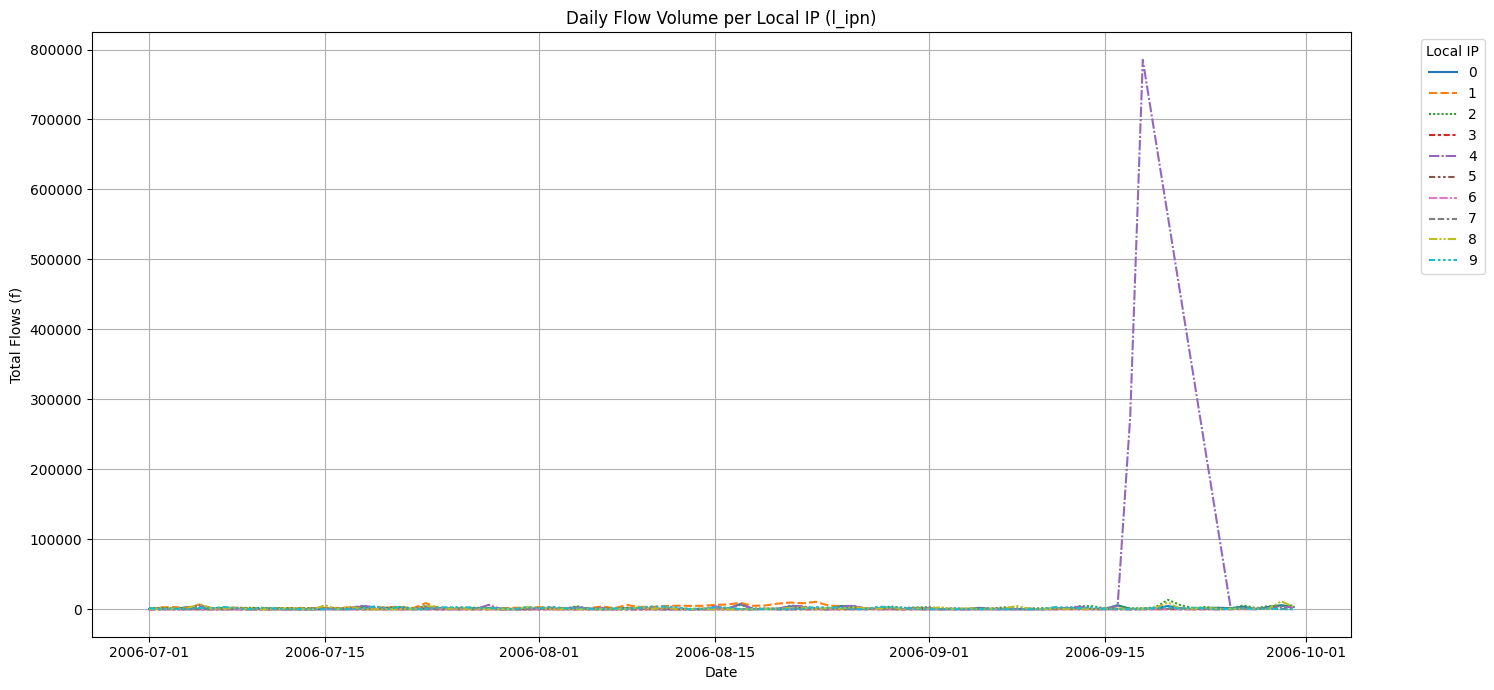

In [7]:
# Group by date and IP to get daily flow volume
daily_flows = df.groupby(['date', 'l_ipn'])['f'].sum().reset_index()

# Pivot for easier visualization
pivot_df = daily_flows.pivot(index='date', columns='l_ipn', values='f')

# Plot the flow spikes for each IP
plt.figure(figsize=(15, 7))
sns.lineplot(data=pivot_df)
plt.title("Daily Flow Volume per Local IP (l_ipn)")
plt.xlabel("Date")
plt.ylabel("Total Flows (f)")
plt.legend(title="Local IP", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Step 1: Ensure data is sorted by IP and date
df_sorted = df.sort_values(by=['l_ipn', 'date'])

# Step 2: Create ASN-to-character mapping (global across all IPs)
unique_asns = df_sorted['r_asn'].unique()
asn_to_char = {asn: chr(65 + i % 26) + (str(i // 26) if i >= 26 else '') for i, asn in enumerate(unique_asns)}

# Step 3: Build per-IP ASN sequences (sequence of remote connections)
ip_asn_sequences = defaultdict(list)
for _, row in df_sorted.iterrows():
    ip = row['l_ipn']
    asn = row['r_asn']
    ip_asn_sequences[ip].append(asn_to_char[asn])
ip_asn_sequences_str = {ip: ''.join(seq) for ip, seq in ip_asn_sequences.items()}

# Step 4: Build per-IP flow-level sequences (summed per day, categorized as a/b/c/d)
# Group by IP and date, summing flows
daily_flows = df.groupby(['l_ipn', 'date'])['f'].sum().reset_index()

# Define buckets: l = low, m = medium, h = high, x = extremely high
def flow_bucket(f):
    if f < 10:
        return 'l'
    elif f < 100:
        return 'm'
    elif f < 1000:
        return 'h'
    else:
        return 'x'

# Apply bucketing to create flow-level strings
daily_flows['flow_level'] = daily_flows['f'].apply(flow_bucket)

# Build sequence per IP
ip_flow_sequences = defaultdict(str)
for _, row in daily_flows.iterrows():
    ip = row['l_ipn']
    ip_flow_sequences[ip] += row['flow_level']

# Return first 100 characters of both encodings for preview
preview_sequences = {
    ip: {
        "flow_levels": ip_flow_sequences[ip][:100],
        "asn_sequence": ip_asn_sequences_str[ip][:100]
    }
    for ip in ip_flow_sequences
}

preview_sequences

{0: {'flow_levels': 'cccdccccbcccccccddcddcdccccdcbccdcccccdccccccccdcccddccddcdccddcccdccccccddccdccdddcddddcddd',
  'asn_sequence': 'ABCDEFGHIJKLMNOPQRSTUVWXYZA1B1C1D1E1F1G1H1I1J1AK1EL1M1N1O1FGP1Q1R1S1T1U1V1RW1UX1Y1Z1A2A1B2C2D2E2F2G2'},
 1: {'flow_levels': 'cdddddddddddddddddddddddcddddddddddddddddddddddddddddddb',
  'asn_sequence': 'Q22CI12N26HZ35N3KY20A36B36C36D36XE36F36J9F7G1K1G36N1N26O1H36Z5GHN2P1N3O3P2X20JLU1S4C36I36V1J36X1K36E'},
 2: {'flow_levels': 'ddddddddddddddccddddddddddddccccccdcdcdcccccccddcdcddddddddddddddcddddcddddddddddddddccddddd',
  'asn_sequence': 'L46GM46N2IN46Q3LU26XO46C25P46I3Q46X41K1L46R46S46T46GN2Q3LU26U46X1C25L46R46O1GV46N2O2P1IW46Q3X46LU26N'},
 3: {'flow_levels': 'bbbbbbbbbbcbbbcbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcbbbbbbbcbbabbbbbbbbbbcbbbbbbbbbbbbbbbcc',
  'asn_sequence': 'CK3HN3C36XM31Y36G1K1O1H36U50HN3P2V50X1M22Q22O1HJ4O2P1N3LQ36Z2Y36E3H27C24S36O1H36HX18O3Q36R3J20E3U6B3'},
 4: {'flow_levels': 'ccccdcccccccccccdddcdcddcccdcccdcbdcdcdccddccdcdcccddccddcdcdc

In [9]:
# Define known compromise dates and IPs
# compromise_info = {
#     1: "2006-08-24",
#     5: "2006-09-04",
#     4: "2006-09-18",
#     3: "2006-09-26",
#     6: "2006-09-26"
# }

# Extract a 7-day window before each compromise date for both flow-level and ASN sequences
pattern_window_days = 7
pattern_data = {}

for ip, date_str in compromise_info.items():
    compromise_date = pd.to_datetime(date_str)
    start_date = compromise_date - pd.Timedelta(days=pattern_window_days)

    # Flow pattern extraction
    daily_flows = df[df['l_ipn'] == ip].groupby(['date'])['f'].sum().reset_index()
    daily_flows = daily_flows[(daily_flows['date'] >= start_date) & (daily_flows['date'] < compromise_date)]
    daily_flows['flow_level'] = daily_flows['f'].apply(lambda f: 'a' if f < 10 else 'b' if f < 100 else 'c' if f < 1000 else 'd')
    flow_pattern = ''.join(daily_flows.sort_values('date')['flow_level'].tolist())

    # ASN pattern extraction
    asn_df = df[(df['l_ipn'] == ip) & (df['date'] >= start_date) & (df['date'] < compromise_date)].sort_values('date')
    asn_sequence = ''.join([asn_to_char[asn] for asn in asn_df['r_asn']])

    pattern_data[ip] = {
        'date_range': f"{start_date.date()} to {compromise_date.date()}",
        'flow_pattern': flow_pattern,
        'asn_pattern': asn_sequence[:100]  # limit for preview
    }

pattern_data

{1: {'date_range': '2006-08-17 to 2006-08-24',
  'flow_pattern': 'ddddddd',
  'asn_pattern': 'Y38H24Z32W3V1I36V16R3A7H6P29LF36E5Z43N8N26D38GN2K31P1L45HK24F36I6Y23V19P6N11Z32N28P45S6O38G25D23Y2A1'},
 5: {'date_range': '2006-08-28 to 2006-09-04',
  'flow_pattern': 'bbbbbbb',
  'asn_pattern': 'K3K51S17L16N17E13E51VLQ3JF11P1HF27R10N51L16M51A1VE46O34M27L51E51LQ3Y20D6P1HGK3E13G25B28N31J14VK5E13L'},
 4: {'date_range': '2006-09-11 to 2006-09-18',
  'flow_pattern': 'cddccdd',
  'asn_pattern': 'GC39A4V8H3LIN2F36E34H3P38C39Y13J32D31F36V1LC31L35O50HGEP48H2Y4H3C39E7J32F36E53P53LEN1GL14N2JHK5H2F36'},
 3: {'date_range': '2006-09-19 to 2006-09-26',
  'flow_pattern': 'bbbbbbb',
  'asn_pattern': 'T52D23G25N35Q19N17A8Z13N3HL2I12AH20A7D23T28R3Z2K5L2P2J4HO1I33R31R33T33N32J8S17V52T28N7U52P15K5J15M3H'},
 6: {'date_range': '2006-09-19 to 2006-09-26',
  'flow_pattern': 'bbbbbbc',
  'asn_pattern': 'T52D23G25N35H32N17Z13JP2HI12AA8Z2Y4D23N56T28R3A7O3R31P2J4HL2O1K5R43S17R33T28P33U52O56L4K5P2N3J15HI33'}}

For More Realistic Streaming Simulation:
- Better Way: Implement the functions to process data chunk-by-chunk or character-by-character as it arrives, rather than having the whole text string available upfront.
- How: This usually involves:
Using generators (yield) to feed data pieces to the matching function.
Designing the matching function to maintain its state between receiving pieces of data. KMP is actually well-suited for this because the LPS array represents the state needed to resume matching. The Naive approach with the deque also maintains state implicitly.
Why: This more closely models real-world scenarios where you don't have the entire data stream in memory at once. You process it incrementally. This is a more significant code structure change.

In [10]:
def stream_data(data, chunk_size=1):
    """
    Simulate streaming
    """
    for i in range(0, len(data), chunk_size):
        yield data[i : i + chunk_size]
        time.sleep(0.05)

In [11]:
# compare string
def str_match(str1, str2):
    if len(str1) != len(str2):
        return False
    for i in range(len(str1)):
        if str1[i] != str2[i]:
            return False
    return True

# Naive pattern matching
def naive_stream_matching(stream, pattern):
    window = deque(maxlen=len(pattern))
    matches = []
    position = 0  # global position in stream

    for chunk in stream:
        for char in chunk:
            window.append(char)
            if len(window) == len(pattern):
                current_window = ''.join(window)
                if current_window == pattern:
                    matches.append(position - len(pattern) + 1)
            position += 1

    return matches


In [81]:
# longest prefix-suffix function
def compute_lps(pattern):
    m = len(pattern)
    lps = [0] * m
    j = 0
    i = 1

    while i < m:
        if pattern[i] == pattern[j]:
            j += 1
            lps[i] = j
            i += 1
        else:
            if j != 0:
                j = lps[j-1]
            else:
                lps[i] = 0
                i += 1
    return lps

# KMP pattern matching
def kmp_stream_matching(stream, pattern, delay=0.0):
    # n = len(text)
    m = len(pattern)
    lps = compute_lps(pattern)
    i = 0
    j = 0
    matches = []

    try:
        while True: 
            char = next(stream)
            time.sleep(delay)

            while j > 0 and char != pattern[j]:
                j = lps[j - 1]

            if char == pattern[j]:
                j += 1  

            if j == m:
                matches.append(i - m + 1)
                j = lps[j - 1]

            i += 1

    except StopIteration:
        # End of stream reached
        pass 

    return matches


In [12]:
text = ip_flow_sequences[1]
pattern = pattern_data[1]['flow_pattern']
stream = stream_data(text, chunk_size=2)

In [13]:
naive_result = ()

start = time.time()
naive_matches = naive_stream_matching(stream, pattern)
end = time.time()
naive_result = (len(naive_matches), end - start)

print("Results")
print("Naive: matches: " + str(naive_result[0]) + ", runtime: " + str(naive_result[1]))

Results
Naive: matches: 41, runtime: 1.4988422393798828


In [84]:
kmp_result = ()
start = time.time()
kmp_matches = kmp_stream_matching(text, pattern)
end = time.time()
kmp_result = (len(kmp_matches), end - start)

print("Results")
print("KMP: matches: " + str(kmp_result[0]) + ", runtime: " + str(kmp_result[1]))

Results
KMP: matches: 41, runtime: 2.8133392333984375e-05
